In [1]:
import numpy as np
import scipy
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.rcParams['pdf.fonttype'] = 42

import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.io import loadmat
import os, sys, string, glob
import torchvision.transforms as transforms
from  collections import defaultdict
from sklearn.linear_model import LassoCV, RidgeCV

strlist = list(string.ascii_lowercase) # storing charaacters from A-Z
%run training_code/clean_cornets.py

In [2]:
# Loading word selective stimuli
neuid_e = [  5,   6,  11,  12,  15,  17,  27,  29,  39,  40,  41,  49,  55,
        56,  65,  71,  73,  75,  78,  89,  90,  91, 111, 123, 131, 150,
       155, 163, 169, 173, 179, 180, 190, 193, 197, 201, 218, 220, 222,
       229, 231, 241, 243, 245, 248, 249, 273, 277, 283, 291, 306, 337,
       341, 343, 351, 352, 356, 357, 363, 365, 375, 376, 378, 381, 382,
       385, 392, 414, 422, 423, 427, 428, 430, 437, 476, 481, 485, 488,
       496, 497, 498, 506]

neuid_c = [  5,   6,  11,  15,  17,  27,  29,  37,  39,  40,  41,  47,  49,
        55,  58,  71,  75,  78,  89,  90,  91,  95, 111, 112, 124, 128,
       137, 145, 150, 155, 163, 165, 169, 179, 180, 186, 190, 197, 201,
       203, 206, 218, 220, 221, 222, 229, 231, 241, 243, 245, 247, 248,
       249, 250, 259, 275, 283, 291, 298, 300, 306, 313, 331, 337, 341,
       351, 352, 355, 357, 361, 363, 365, 375, 376, 378, 381, 382, 385,
       386, 391, 392, 414, 415, 416, 417, 423, 427, 428, 435, 437, 449,
       458, 461, 463, 473, 476, 481, 485, 488, 496, 497, 498, 502, 503, 506]

neuid_ec = np.intersect1d(neuid_c,neuid_e)

nid = {}
qt = list(set(neuid_e)^set(neuid_ec));    nid[0] = np.reshape(qt,[np.size(qt),1])
qt = list(set(neuid_c)^set(neuid_ec));    nid[1] = np.reshape(qt,[np.size(qt),1])
qt = list(set([])^set(neuid_ec));         nid[2] = np.reshape(qt,[np.size(qt),1])
type = ['English','Chinese','English+Chinese']

In [5]:
# Loading activations for the vinckier stimuli
net = CORNet_Z_nonbiased_words()
checkpoint = torch.load('models/save_lit_no_bias_z_79_full_nomir.pth.tar')['state_dict']
for key in list(checkpoint.keys()):
    if 'module.' in key:
        checkpoint[key.replace('module.', '')] = checkpoint[key]
        del checkpoint[key]
net.load_state_dict(checkpoint)

## Vinckier stimuli  
data_dir = 'stimuli/vinckier240/'
transform = {'train': transforms.Compose([transforms.Resize((224,224)),
transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])}

chosen_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform[x]) for x in ['train']}
dataloaders = {x: torch.utils.data.DataLoader(chosen_datasets[x], batch_size = 80) for x in ['train']}
dataiter = iter(dataloaders['train'])

VnBli = {};  VnBli['h'] = []
for i in range(18):
    stimtemp, classes = next(dataiter)
    _,_,_,_,varh, _ = net(stimtemp.float())
    VnBli['h'].extend(varh.detach().numpy())
    print(i)
    
print('Full Vinckier data loaded')

Full Vinckier data loaded


['FUYAIT',
 'SIPHON',
 'GAZEUX',
 'SCOTCH',
 'AFFLUX',
 'MYOPIE',
 'CHAHUT',
 'GLOBES',
 'FIXAIT',
 'BOUGEZ',
 'MAXIME',
 'BONBON',
 'LACHEZ',
 'BOXEUR',
 'STOCKS',
 'AXIOME',
 'PUBLIC',
 'ENVOYE',
 'CHABOT',
 'LUXURE',
 'NOYAIT',
 'BUFFLE',
 'EXPOSA',
 'HAGARD',
 'MEFIEZ',
 'GALOPE',
 'FURTIF',
 'GAZONS',
 'RYTHME',
 'BOULEZ',
 'GRIMPA',
 'TOUFFE',
 'BAMBIN',
 'CYCLES',
 'BAFOUE',
 'CYPRES',
 'AMBIGU',
 'CROYEZ',
 'MAXIMA',
 'BOEUFS',
 'AVACHI',
 'OBJETS',
 'APPUYA',
 'FIXENT',
 'COBAYE',
 'REFLUX',
 'VOYAIS',
 'PUZZLE',
 'VOYAIT',
 'ZEBRES',
 'JOYAUX',
 'MANGEZ',
 'BOUBOU',
 'CHAPPE',
 'STYLOS',
 'CODAGE',
 'BIKINI',
 'LOYALE',
 'PHENIX',
 'MAZOUT',
 'GRIPPE',
 'ENVOYA',
 'SUFFIT',
 'LAVABO',
 'TRUFFE',
 'WALLON',
 'POUFFE',
 'BAVARD',
 'COIFFE',
 'PYJAMA',
 'BOUFFE',
 'LARYNX',
 'AVOUEZ',
 'BAYARD',
 'INFLUX',
 'JOCKEY',
 'ABUSIF',
 'JONCHE',
 'AFFALA',
 'BRIDGE',
 'PYTHON',
 'AFFAME',
 'VOYONS',
 'LEZARD',
 'TOUBIB',
 'GARDEZ',
 'SOYONS',
 'EFFACA',
 'JARGON',
 'MYTHES',
 'JALOUX',

In [15]:
# Model fitting different categories of Vinckier stimuli

# Response to word specific units
wordSelUnit = np.sort(nid[0].flatten())
x = np.array(VnBli['h']) #stimulus 
Vli_obs = x[:,wordSelUnit]

# Loading stimuli names
Vwordlist = []; nstimpercat = 240
for file in glob.glob("D:/2_Research/UNICOG/experiments/DNN/Github-Thomas/others/StimulusProperties/*.txt"):
    if not file[-6:-4] == 'NV':
        file1 = open(file,"r") 
        x = (file1.read()).split('\n')
        Vwordlist = np.concatenate((Vwordlist, x[:nstimpercat]))

#  Building regression matrix
Vxmat = np.zeros((len(Vwordlist), 26*8))
for i, seq in enumerate(Vwordlist):
    offset = int(4-len(seq)/2)
    for j, char in enumerate(seq.lower()): 
        if char in strlist:
            pid = (strlist.index(char)*8) + j #+offset # Encoding position information
            Vxmat[i,pid] += 1  # Assigning ones at corresponding locations      
            

    
##### Initializing variables
Vrfit = np.zeros((len(wordSelUnit), 6,6))
coefMat = np.zeros((len(wordSelUnit),6, 26*8))

################ Model fitting  ######################
for neu in range(len(wordSelUnit)): 
    for vcat in range(6):
        Xmat_tr = Vxmat[(vcat)*nstimpercat:(vcat+1)*nstimpercat,:]
        Yobs_tr = Vli_obs[(vcat)*nstimpercat:(vcat+1)*nstimpercat,neu]
        
        reg = LassoCV(cv=5, random_state=42,max_iter=10000).fit(Xmat_tr, Yobs_tr)   
        coefMat[neu,vcat,:] = reg.coef_

    
        for i in range(6):
            corrval,_ = scipy.stats.pearsonr(Vxmat[(i)*nstimpercat:(i+1)*nstimpercat,:]@reg.coef_, 
                                             Vli_obs[(i)*nstimpercat:(i+1)*nstimpercat,neu])
            Vrfit[neu,vcat,i] = corrval**2 
     
    
# plt.hist(rfit, bins= np.arange(0,1,.1), rwidth= .8, alpha = 0.5)
# plt.hist(Vrfit[:,5],bins = np.arange(0,1,.1),alpha = 0.5, rwidth= .8)
# plt.xlabel('Cross-Validated score (R^2)'); plt.ylabel('Count')
# plt.title('English word selective units - h layer')
# plt.legend(['Trained words','Vinckier words'])

# Ravg = np.append(np.nanmean(Vrfit,0),np.nanmean(rfit))
# plt.figure(2); plt.bar(range(7),Ravg)
# plt.ylabel('Cross-Validated score (R^2)')
# plt.title('English word selective units - h layer')
# plt.xticks(ticks = range(7),labels=['FF','IL','FL','FB','FQ','Vword','500Word']);

D:\software_installation\Anaconda\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


<BarContainer object of 6 artists>

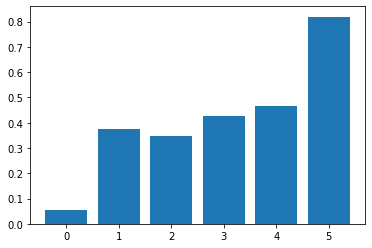

In [30]:
plt.bar(range(6),np.nanmean(Vrfit[:,5,:],0))